# Problem 3 Sample Code

This sample code is meant as a guide on how to use PyTorch and how to use the relevant model layers. This not a guide on how to design a network and the network in this example is intentionally designed to have poor performace.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [ ]:
print(len(train_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))

60000 <class 'torch.Tensor'> <class 'int'>


In [ ]:
print(torchvision.transforms.functional.get_image_size(train_dataset[0][0]))

[28, 28]


In [ ]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


We can convert images to numpy arrays and plot them with matplotlib:

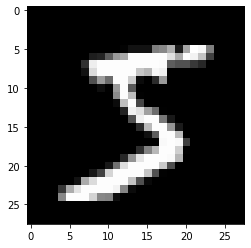

In [ ]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Network Definition
Let's instantiate a model and take a look at the layers.

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0),
    nn.Linear(100, 10)
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)


## Training
We also choose an optimizer and a loss function.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

We could write our training procedure manually and directly index the `Dataset` objects, but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

We now write our backpropagation loop, training for 10 epochs.

In [ ]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.0902
Train Epoch: 2  Loss: 0.0421
Train Epoch: 3  Loss: 0.3539
Train Epoch: 4  Loss: 0.0062
Train Epoch: 5  Loss: 0.0174
Train Epoch: 6  Loss: 0.0477
Train Epoch: 7  Loss: 0.0282
Train Epoch: 8  Loss: 0.1151
Train Epoch: 9  Loss: 0.0024
Train Epoch: 10  Loss: 0.0028


## Testing
We can perform forward passes through the network without saving gradients.

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0026, Accuracy: 9770/10000 (97.7000)
